<a href="https://colab.research.google.com/github/batuhanyndny/intro/blob/master/Early_Stopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

## Install dependencies

**Check for GPU**

First make sure the nvidia-smi command returns information about the available GPU. If it does not, click Runtime > Change runtime type > Hardware accelerator > GPU. Then run the nvidia-smi command again.

In [0]:
!nvidia-smi

Sat Nov 24 20:38:14 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl torchvision

    100% |████████████████████████████████| 512.6MB 50.0MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58054000 @  0x7f6f999752a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 2.0MB 5.2MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
!git clone https://github.com/sg2/intro

Cloning into 'intro'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 401 (delta 8), reused 4 (delta 0), pack-reused 379
Receiving objects: 100% (401/401), 17.14 MiB | 8.03 MiB/s, done.
Resolving deltas: 100% (160/160), done.


In [0]:
cd intro/8-EarlyStopping

/content/intro/8-EarlyStopping


Early stopping
=====================
Adapted from https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

Data should be split into train/dev/test splits.

1. Training set: a set of examples used for learning: to fit the parameters of the classifier.

2. Dev set: a set of examples used to tune the parameters of a classifier. We would use the validation set to find the "optimal" number of hidden units or determine a stopping point for the back-propagation algorithm.

3. Test set: a set of examples used only to assess the performance of a fully-trained classifier. We use this test to estimate the error rate after we have chosen the final model. After assessing the final model on the test set, YOU MUST NOT tune the model any further!

Reference: https://stats.stackexchange.com/questions/19048/what-is-the-difference-between-test-set-and-validation-set

## Early stopping
Early stopping is a technique to prevent over-fitting to the train set.

![](https://github.com/sg2/intro/blob/master/8-EarlyStopping/images/early_stopping.png?raw=1)

## 1. Load and normalizing the CIFAR10 training and test datasets using
Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

Set the device to GPU

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

devset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
devloader = torch.utils.data.DataLoader(devset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [0]:
print(len(trainset))
print(len(devset))

50000
10000


Let us show some of the training images, for fun.



  car truck   cat  bird


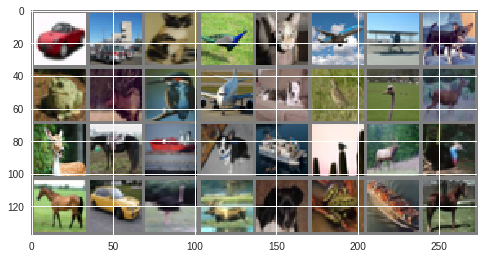

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolution Neural Network

Needs 3 channels for first layer.



In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network


This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [0]:
running_losses = []
dev_losses = []
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0   
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        dev_losses.append(loss.item())
        if i % 200 == 199:    # print every 200 mini-batches
          
          with torch.no_grad():
            for data in devloader:  
              images, labels = data
              images, labels = images.to(device), labels.to(device)
              outputs = net(images)
              dev_loss = criterion(outputs, labels)
              dev_losses.append(dev_loss.item())
          
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 200))
            print(dev_loss.item())
            running_losses.append(running_loss)
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 2.303
2.310302972793579
[1,   400] loss: 2.301
2.3071231842041016
[1,   600] loss: 2.298
2.3007514476776123
[1,   800] loss: 2.293
2.2867696285247803
[1,  1000] loss: 2.278
2.2421200275421143
[1,  1200] loss: 2.219
2.0429227352142334
[1,  1400] loss: 2.101
1.782462239265442
[2,   200] loss: 1.936
1.729806900024414
[2,   400] loss: 1.901
1.5404787063598633
[2,   600] loss: 1.846
1.661805510520935
[2,   800] loss: 1.786
1.4756669998168945
[2,  1000] loss: 1.764
1.4791368246078491
[2,  1200] loss: 1.732
1.7173326015472412
[2,  1400] loss: 1.686
1.5652122497558594
[3,   200] loss: 1.640
1.484702229499817
[3,   400] loss: 1.621
1.440643310546875
[3,   600] loss: 1.593
1.450792670249939
[3,   800] loss: 1.566
1.500553011894226
[3,  1000] loss: 1.577
1.3825150728225708
[3,  1200] loss: 1.556
1.370942234992981
[3,  1400] loss: 1.554
1.5019736289978027
[4,   200] loss: 1.512
1.2737939357757568
[4,   400] loss: 1.469
1.2772724628448486
[4,   600] loss: 1.477
1.2861584424972534
[

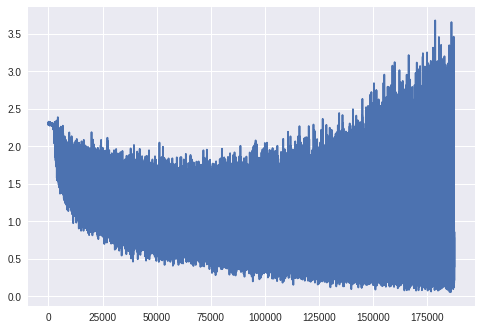

In [0]:
plt.plot(dev_losses)

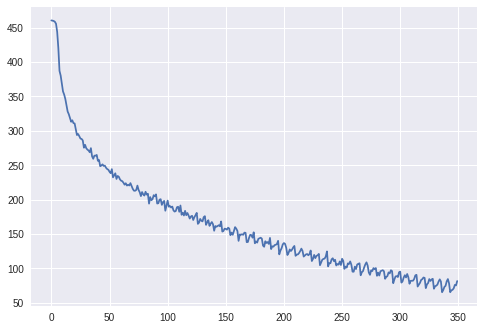

In [0]:
plt.plot(running_losses)

## 5. Test the network on the test data


We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f0ed0cd9438>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil

GroundTruth:    cat  ship  ship plane


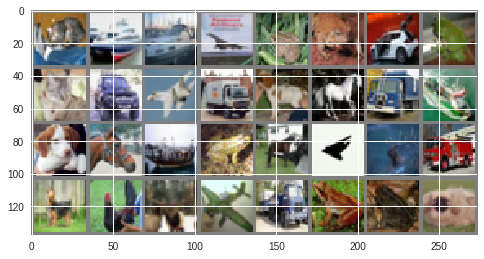

In [0]:
dataiter = iter(devloader)
images, labels = dataiter.next()

images, labels = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = net(images)
print(outputs)

tensor([[ -6.1477,  -2.1378,  -2.3421,   7.8311,   1.1501,  -3.0748,   2.2785,
          -1.1331,  -0.9760,   1.5513],
        [  4.0364,  11.2415,  -1.6066,  -3.8355,  -9.1252,  -3.2870,  -4.2555,
          -9.8569,   4.8678,   6.2847],
        [  4.7969,   6.0867,  -2.4716,  -2.4567,  -1.6787,  -5.9109,  -9.5969,
          -2.0898,   7.3684,   5.1899],
        [  9.9925,   8.3704,   0.0381,   1.1850,  -5.5523,  -6.0272,  -5.2645,
          -8.1138,   3.7371,  -1.0623],
        [ -5.1178,  -3.6057,   1.5910,   5.0959,   3.6531,   0.0744,   9.5628,
          -5.6273,  -5.1756,  -3.6084],
        [ -2.0981,  -2.0845,   0.2872,  -0.6708,  -3.5591,   0.4123,   8.2610,
          -3.0747,  -0.1844,   1.6999],
        [  3.1874,   9.0735,   6.7134,  -6.4336,  -8.5804,   1.6386,  -5.4760,
          -3.9540,  -0.4834,   0.0244],
        [  3.1661,  -7.1986,   8.1552,   2.3070,   0.7286,  -4.9578,  12.5020,
         -10.5880,  -6.1467,  -3.0939],
        [ -2.1816,  -5.9307,   2.5460,   8.1468,

The outputs are logits for the 10 classes.
Higher the logits for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest logit:



In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in devloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in devloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 85 %
Accuracy of  bird : 55 %
Accuracy of   cat : 40 %
Accuracy of  deer : 44 %
Accuracy of   dog : 51 %
Accuracy of  frog : 69 %
Accuracy of horse : 63 %
Accuracy of  ship : 76 %
Accuracy of truck : 66 %
